
<center><h1> Alphabet and Digit recognition using Convolution Neural Network  </h1></center>

<h4>Importing Required Librarires</h4>

In [1]:
# import Numpy and Pandas for handling arrays and loading csv files
import numpy as np
import pandas as pd

# for reading and displaying images, import imread and matplotlib
import matplotlib.pyplot as plt

# for creating validation set, import train_test_split; understand how the function works
from sklearn.model_selection import train_test_split

# for evaluating the model, import accuracy_score from sklearn
from sklearn.metrics import accuracy_score

# Import necessary PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import dataset from pytorch vision -  MNIST
import torchvision
import torchvision.transforms as transforms

<center><h1>********************* Digit Classification ********************</h1></center>

Downloading MNIST dataset from torchvision<br>
About MNIST Dataset:<br>
<ul>
    <li> Dataset for Handwritten digits</li>
    <li> Consist of 60000 images for training and 10000 images for testing</li>
    <li> Images has dimension / pixel of 28 x 28 in gray scale</li>
</ul>



In [2]:
# load dataset and use dataloader to send the data in batches.

# transforms is used to Convert data/PIL images  to tensor and normalise it.
# Its needed because Images are in the format of PIL Images so to convert
# into tensor and to normalize as the number are ranging from 0 to 255.
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

# Loading training images after downloading with transforming simultaneously using transform variable
Dig_trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)

# DataLoader is use to pass data in batches while training or whenever it is required.
Dig_trainloader = torch.utils.data.DataLoader(Dig_trainset, batch_size=4,shuffle=True, num_workers=2)

# Loading testing images after downloading with transforming simultaneously using transform variable
Dig_testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

# DataLoader is use to pass data in batches while training or whenever it is required.
Dig_testloader = torch.utils.data.DataLoader(Dig_testset, batch_size=4,shuffle=False, num_workers=2)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [3]:
# Checking the length of training set of digit dataset
print("Length of training set : ",len(Dig_trainset))
image,label=Dig_trainset[0]
print(image.shape)
print(label)

Length of training set :  60000
torch.Size([1, 28, 28])
5


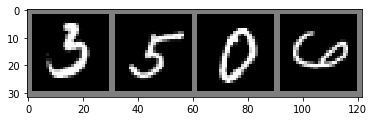

tensor(3) tensor(5) tensor(0) tensor(6)


In [4]:
# Visualise some random images from the dataset.
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images with the help of data iterator
dataiter = iter(Dig_trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [5]:
'''
Class 'Net_for_Dig' which is used to create convolution neural network for 
classification of digit and it is a sub class which uses its super class 
namely 'nn.Module' which is provided by torch library.There are following funtions:

        1. __init__ : This Function is always required for a class which is used
                      to initialise variables. Here, this class first initialised
                      variables of its super class.Then, it initialised its own 
                      variables which are basically layers of convolution neural
                      network.
                      First Variable is "conv1" which is first Convolution layer of 
                      network which is initialised with inbuilt convolution layer 
                      provided by torch.nn .This layer will accept the inputs in batches
                      with one channel, then it outputs 32 channels with the help of
                      kernel of size 3 and padding 1.
                      
                      Second Variable is "pool" which is initialised with Max Pool Layer
                      provided by torch.nn with kernel size 2 and stride 2.This layer 
                      can be used after any layer whenever we want to reduce the dimension.
                      
                      Third Variable is "conv2" which is second Convolution layer of 
                      network which is initialised with inbuilt convolution layer 
                      provided by torch.nn .This layer will accept the inputs in batches
                      with 32 channel (output by previous layer), then it outputs 64 channels
                      with the help of kernel of size 3.
                      
                      Fourth Variable is "fc1" which is first fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 64*6*6 (This can be decided on 
                      our own) and it outputs 600 units(decided on our own).
                      
                      Fifth Variable is "drop" which is object of dropout layer which is
                      used to prevent the model from overfitting.Layer is provided by 
                      torch.nn .It takes probability( values getting 0) as input.
                      
                      Sixth Variable is "fc2" which is second fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 600 ( output from previous layer)
                      and it outputs 120 units(decided on our own).
                      
                      Seventh Variable is "fc3" which is last fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 120 ( output from previous layer)
                      and it outputs 10 units(total number of classes).
                      
        2. forward: This Function is used to forward propagate in the neural network which is
                    called by it super class.This function is provided by the input that we are
                    going to feed in the neural network.
                    Flow of the network:
                    1.Feeded to convolution layer 1
                    2.Passed through ReLU Layer (Activation Layer)
                    3.Passed through Max Pooling Layer
                    4.Feeded to convolution layer 2
                    5.Passed through ReLU Layer (Activation Layer)
                    6.Passed through Max Pooling Layer
                    
                    Squeezed all values to one dimension so that it can be feeded in Linear Layer
                    
                    7.Passed through Fully Connected Layer 1
                    8.Passed through ReLU Layer(Activation Layer)
                    9.Passed through Dropout Layer
                    10.Passed through Fully Connected Layer 2
                    11.Passed through ReLU Layer(Activation Layer)
                    12.Passed through Last Fully connected layer.
                    
                    Last Layer give the pobabilty of the classes from which answer will be the 
                    class which has max probability.
                    This value is returned by this function.
                    
'''
class Net_for_Dig(nn.Module):
    def __init__(self):
        super(Net_for_Dig, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Training Time!

In [10]:
#******************************ADAM as OPTIMIZER && CROSS ENTROPY as LOSS Func********************************
# Define training the model
Dig_net = Net_for_Dig()

# defining the optimizer
optimizer = optim.Adam(Dig_net.parameters(), lr=0.001)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# For each epoch and in each batch:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Dig_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # clear the gradients
        optimizer.zero_grad()

        # compute the model output
        outputs = Dig_net(inputs)
        
        # calculate loss
        CELloss = criterion(outputs, labels)
        
        # propagate loss backwards
        CELloss.backward()
        
        # update model weights
        optimizer.step()
        
        # print statistics
        running_loss += CELloss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] CELloss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] CELloss: 0.357
[1,  4000] CELloss: 0.138
[1,  6000] CELloss: 0.123
[1,  8000] CELloss: 0.098
[1, 10000] CELloss: 0.092
[1, 12000] CELloss: 0.089
[1, 14000] CELloss: 0.076
[2,  2000] CELloss: 0.065
[2,  4000] CELloss: 0.083
[2,  6000] CELloss: 0.073
[2,  8000] CELloss: 0.066
[2, 10000] CELloss: 0.060
[2, 12000] CELloss: 0.060
[2, 14000] CELloss: 0.079
Finished Training


In [11]:
#Saving the trained model in the PATH
PATH = './Adam_CEL_MNIST_net_ep2.pth'
torch.save(Dig_net.state_dict(), PATH)

In [6]:
# Storing back all parameters learnt when trained
PATH = './Adam_CEL_MNIST_net_ep2.pth'
Dig_net = Net_for_Dig()
Dig_net.load_state_dict(torch.load(PATH))  

<All keys matched successfully>

### Learnt Weights and bias for each layer of Convolution Neural Network Dig_net

In [7]:
for name, param in Dig_net.named_parameters():
    print("Name of the layer: ",name)
    print("Parameters: ",param)

Name of the layer:  conv1.weight
Parameters:  Parameter containing:
tensor([[[[ 0.0230, -0.0309, -0.2474],
          [ 0.0524, -0.2072,  0.0135],
          [-0.1576, -0.0854, -0.1005]]],


        [[[-0.1347,  0.0317,  0.1673],
          [-0.2085,  0.2400, -0.1062],
          [ 0.3054, -0.0598, -0.0391]]],


        [[[ 0.2472,  0.0081, -0.0302],
          [ 0.1434, -0.1599, -0.1067],
          [-0.1013, -0.2294,  0.0653]]],


        [[[ 0.1059, -0.2658,  0.1164],
          [-0.1122,  0.1683, -0.1027],
          [-0.1957,  0.0457, -0.0534]]],


        [[[-0.0174, -0.1229,  0.1159],
          [ 0.0083, -0.2369,  0.1579],
          [ 0.1469, -0.1764,  0.1084]]],


        [[[ 0.0775, -0.1984,  0.0273],
          [ 0.1403,  0.1210, -0.1765],
          [-0.0611,  0.2196, -0.1880]]],


        [[[ 0.1537,  0.1196, -0.2961],
          [ 0.3834, -0.1810, -0.0829],
          [ 0.0128,  0.2333, -0.0027]]],


        [[[-0.0735,  0.1147,  0.1634],
          [ 0.2041, -0.1181, -0.0268],
       

Parameters:  Parameter containing:
tensor([[-0.0081, -0.0715,  0.0574,  ...,  0.0333,  0.0243,  0.0668],
        [-0.1221, -0.0394, -0.0789,  ..., -0.1950, -0.2615, -0.2987],
        [ 0.0763, -0.0210, -0.0540,  ..., -0.0355, -0.2372, -0.2545],
        ...,
        [ 0.0553, -0.0249, -0.1454,  ..., -0.0747, -0.1201,  0.0435],
        [-0.1644,  0.0262, -0.4809,  ..., -0.0870, -0.0270,  0.0498],
        [-0.2888, -0.0394,  0.0748,  ..., -0.2171, -0.0425, -0.1535]],
       requires_grad=True)
Name of the layer:  fc3.bias
Parameters:  Parameter containing:
tensor([-0.0438,  0.0788, -0.0590, -0.0231,  0.0767, -0.1086, -0.1369, -0.0259,
         0.0564, -0.1384], requires_grad=True)


# Testing Time!

In [8]:
#****************************** Adam as OPTIMIZER && Cross Entropy as LOSS Func ********************************

# Evaluate model on test set. This is done in the same way as for training but only till calculating output.
correct = 0
total = 0
prediction=[]
Actual=[]
with torch.no_grad():
    for data in Dig_testloader:
        images, labels = data
        outputs = Dig_net(images)
        _, predicted = torch.max(outputs.data, 1)
        prediction.extend(predicted)
        Actual.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 

 
#Then,convert output from tensor to numpy format.
# convert to class labels
# store the predictions
prediction=np.array(prediction)
Actual=np.array(Actual)

print("******************* ADAM AS OPTIMIZER && CEL AS LOSS FUNC ********************")
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# calculate accuracy of model
print('Accuracy(USING SKLEARN) of the network on the 10000 test images: %' ,100*accuracy_score(Actual,prediction))


******************* ADAM AS OPTIMIZER && CEL AS LOSS FUNC ********************
Accuracy of the network on the 10000 test images: 98 %
Accuracy(USING SKLEARN) of the network on the 10000 test images: % 98.09


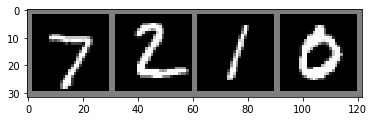

GroundTruth:  tensor(7) tensor(2) tensor(1) tensor(0)
Predicted:  tensor(7) tensor(2) tensor(1) tensor(0)


In [9]:
# check predictions by printing the output image for random test inputs.
dataiter = iter(Dig_testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs=Dig_net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(4)))

<center><h1>****************** Alphabet Classification ******************</h1></center>

About Alphabet dataset:<br>
Link for the Alphabet dataset is:
https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format?select=A_Z+Handwritten+Data.csv

This A-Z Alphabet Dataset consist more than 3 Lakh examples in numerical/pixel form in csv format.
This will take a lot of time to train and test. Since the accuracy doesn't matter for this assignment, so
I decided to reduce the number of examples to 2600 with each class has 100 examples.

So, code to reduce the data:
***********************************************
<code>
data = pd.read_csv("A_Z_Handwritten_Data.csv")
data = np.array(data)

Mdata=[]
for i in range(26):
    T=data[data[:,0]==i]
    T=T[ np.random.choice( T.shape[0],100, False),:]
    Mdata.extend(list(T))

Mdata=np.array(Mdata)
df=pd.DataFrame(Mdata)
df.to_csv("Modified_Data.csv",index=False)
</code>

************************************************
New Modified Data is saved, Link to access the data is:
https://docs.google.com/spreadsheets/d/13rkn6KFFe3JkC1DVyh26FiNUNQJxEMqxwKXNwevDXkM/edit?usp=sharing


In [10]:
# Loading the main csv file in which first index is the row number 
# second index is class label, from third image vector of dim 784
Alph_data = pd.read_csv("Modified.csv")
print("Shape of Alph_data: ",Alph_data.shape)

# Separating image (in float32 datatype) and label
X_Alph = (Alph_data.iloc[:,2:786].values).astype('float32')
Y_Alph = (Alph_data.iloc[:,1].values)
print("Input Matrix of Shape: ",X_Alph.shape)
print("True Labels of Shape: ",Y_Alph.shape)

# separating for train and test data using sklearn
X_Alph_train, X_Alph_test, Y_Alph_train, Y_Alph_test = train_test_split(X_Alph,
                                        Y_Alph, test_size=0.30, random_state=42)
print("X-train : ",X_Alph_train.shape)
print("Y-train : ",Y_Alph_train.shape)
print("X-test : ",X_Alph_test.shape)
print("Y-test : ",Y_Alph_test.shape)

# reshaping the data as per model requirement
X_Alph_train = X_Alph_train.reshape(X_Alph_train.shape[0],1, 28, 28)
X_Alph_test = X_Alph_test.reshape(X_Alph_test.shape[0],1, 28, 28)

print("******* After Reshaping ********")
print("X-train : ",X_Alph_train.shape)
print("Y-train : ",Y_Alph_train.shape)
print("X-test : ",X_Alph_test.shape)
print("Y-test : ",Y_Alph_test.shape)



Shape of Alph_data:  (2600, 786)
Input Matrix of Shape:  (2600, 784)
True Labels of Shape:  (2600,)
X-train :  (1820, 784)
Y-train :  (1820,)
X-test :  (780, 784)
Y-test :  (780,)
******* After Reshaping ********
X-train :  (1820, 1, 28, 28)
Y-train :  (1820,)
X-test :  (780, 1, 28, 28)
Y-test :  (780,)


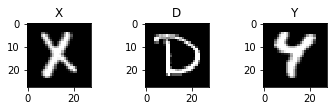

In [11]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_Alph_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(chr(Y_Alph_train[i]+65))

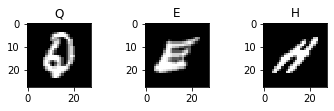

In [12]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_Alph_test[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(chr(Y_Alph_test[i]+65))

In [13]:
# Converting the data into Tensor Dataset because everything will be in tensor
X_Alph_train_tensor = torch.tensor(X_Alph_train)/255.0
Y_Alph_train_tensor = torch.tensor(Y_Alph_train)
Alph_train_tensor = torch.utils.data.TensorDataset(X_Alph_train_tensor, Y_Alph_train_tensor)

X_Alph_test_tensor = torch.tensor(X_Alph_test)/255.0
Y_Alph_test_tensor = torch.tensor(Y_Alph_test)
Alph_test_tensor = torch.utils.data.TensorDataset(X_Alph_test_tensor, Y_Alph_test_tensor)

# Making Data loader which passes the data while training or any job, in batches
Alph_train_loader = torch.utils.data.DataLoader(Alph_train_tensor, batch_size=4, num_workers=2, shuffle=True)
Alph_test_loader =torch.utils.data.DataLoader(Alph_test_tensor, batch_size=4, num_workers=2, shuffle=False)


In [14]:
'''
Class 'Net_for_Alph' which is used to create convolution neural network for 
classification of Alphabets and it is a sub class which uses its super class 
namely 'nn.Module' which is provided by torch library.There are following funtions:

        1. __init__ : This Function is always required for a class which is used
                      to initialise variables. Here, this class first initialised
                      variables of its super class.Then, it initialised its own 
                      variables which are basically layers of convolution neural
                      network.
                      First Variable is "conv1" which is first Convolution layer of 
                      network which is initialised with inbuilt convolution layer 
                      provided by torch.nn .This layer will accept the inputs in batches
                      with one channel, then it outputs 32 channels with the help of
                      kernel of size 3 and padding 1.
                      
                      Second Variable is "pool" which is initialised with Max Pool Layer
                      provided by torch.nn with kernel size 2 and stride 2.This layer 
                      can be used after any layer whenever we want to reduce the dimension.
                      
                      Third Variable is "conv2" which is second Convolution layer of 
                      network which is initialised with inbuilt convolution layer 
                      provided by torch.nn .This layer will accept the inputs in batches
                      with 32 channel (output by previous layer), then it outputs 64 channels
                      with the help of kernel of size 3.
                      
                      Fourth Variable is "fc1" which is first fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 64*6*6 (This can be decided on 
                      our own) and it outputs 600 units(decided on our own).
                      
                      Fifth Variable is "drop" which is object of dropout layer which is
                      used to prevent the model from overfitting.Layer is provided by 
                      torch.nn .It takes probability( values getting 0) as input.
                      
                      Sixth Variable is "fc2" which is second fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 600 ( output from previous layer)
                      and it outputs 120 units(decided on our own).
                      
                      Seventh Variable is "fc3" which is last fully connected layer of the neural
                      network initialised with help of torch.nn.Linear which is linear layer
                      of network.This object takes input of 120 ( output from previous layer)
                      and it outputs 26 units(total number of classes).
                      
        2. forward: This Function is used to forward propagate in the neural network which is
                    called by it super class.This function is provided by the input that we are
                    going to feed in the neural network.
                    Flow of the network:
                    1.Feeded to convolution layer 1
                    2.Passed through ReLU Layer (Activation Layer)
                    3.Passed through Max Pooling Layer
                    4.Feeded to convolution layer 2
                    5.Passed through ReLU Layer (Activation Layer)
                    6.Passed through Max Pooling Layer
                    
                    Squeezed all values to one dimension so that it can be feeded in Linear Layer
                    
                    7.Passed through Fully Connected Layer 1
                    8.Passed through ReLU Layer(Activation Layer)
                    9.Passed through Dropout Layer
                    10.Passed through Fully Connected Layer 2
                    11.Passed through ReLU Layer(Activation Layer)
                    12.Passed through Last Fully connected layer.
                    
                    Last Layer give the pobabilty of the classes from which answer will be the 
                    class which has max probability.
                    This value is returned by this function.
                    
'''
class Net_for_Alph(nn.Module):
    def __init__(self):
        super(Net_for_Alph, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Time!

In [20]:
#******************************ADAM as OPTIMIZER && CROSS ENTROPY as LOSS Func********************************

# Define training the model
Alph_net = Net_for_Alph()

# defining the optimizer
optimizer = optim.Adam(Alph_net.parameters(), lr=0.001)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# For each epoch and in each batch:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(Alph_train_loader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs,labels = data
        
        # clear the gradients
        optimizer.zero_grad()

        # compute the model output
        outputs = Alph_net(inputs)
        
        # calculate loss
        CELloss = criterion(outputs, labels)
        
        # propagate loss backwards
        CELloss.backward()
        
        # update model weights
        optimizer.step()
        
        # print statistics
        running_loss += CELloss.item()
        if i % 400 == 399:    # print every 2000 mini-batches
            print('[%d, %5d] CELloss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   400] CELloss: 0.428
[2,   400] CELloss: 0.136
[3,   400] CELloss: 0.076
[4,   400] CELloss: 0.054
Finished Training


In [21]:
#Saving the trained model in the PATH
PATH = './Adam_CEL_Alph_net_ep4.pth'
torch.save(Alph_net.state_dict(), PATH)

In [15]:
# Storing back the learnt parameters
PATH = './Adam_CEL_Alph_net_ep4.pth'
Alph_net = Net_for_Alph()
Alph_net.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

### Learnt Weights and bias for each layer of Convolution Neural Network Alph_net

In [19]:
for name, param in Alph_net.named_parameters():
    print("Name of the layer: ",name)
    print("Parameters: ",param)

Name of the layer:  conv1.weight
Parameters:  Parameter containing:
tensor([[[[-0.0915, -0.1051, -0.2436],
          [-0.2733, -0.0032, -0.5558],
          [-0.1288, -0.3738, -0.3073]]],


        [[[ 0.0208,  0.3287, -0.3558],
          [ 0.1354,  0.1151, -0.4295],
          [ 0.2860, -0.2505, -0.3308]]],


        [[[ 0.3757, -0.0143, -0.3686],
          [ 0.2583, -0.2774, -0.2772],
          [ 0.0751, -0.2084,  0.0102]]],


        [[[ 0.3413, -0.3350, -0.3071],
          [ 0.0870, -0.2873, -0.0834],
          [ 0.0090, -0.3139,  0.3898]]],


        [[[ 0.0874,  0.4303,  0.1620],
          [-0.1562, -0.2010,  0.3138],
          [-0.3397, -0.1226,  0.2268]]],


        [[[-0.3204,  0.2270,  0.3923],
          [-0.2203,  0.2751, -0.1671],
          [ 0.0946,  0.0619, -0.0473]]],


        [[[-0.0351,  0.2256,  0.3293],
          [-0.0782,  0.1565, -0.3639],
          [ 0.1032, -0.0059, -0.4917]]],


        [[[-0.1105, -0.3346, -0.1819],
          [ 0.3642,  0.3834,  0.0166],
       

# Testing Time!

In [17]:
#****************************** Adam as OPTIMIZER && Cross Entropy as LOSS Func ********************************

# Evaluate model on test set. This is done in the same way as for training but only till calculating output.
correct = 0
total = 0
prediction=[]
Actual=[]
with torch.no_grad():
    for data in Alph_test_loader:
        images, labels = data
        outputs = Alph_net(images)
        _, predicted = torch.max(outputs.data, 1)
        prediction.extend(predicted)
        Actual.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 

 
#Then,convert output from tensor to numpy format.
# convert to class labels
# store the predictions
prediction=np.array(prediction)
Actual=np.array(Actual)

print("******************* ADAM AS OPTIMIZER && CEL AS LOSS FUNC ********************")
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# calculate accuracy of model
print('Accuracy(USING SKLEARN) of the network on the test images: %' ,100*accuracy_score(Actual,prediction))


******************* ADAM AS OPTIMIZER && CEL AS LOSS FUNC ********************
Accuracy of the network on the test images: 83 %
Accuracy(USING SKLEARN) of the network on the test images: % 83.33333333333334


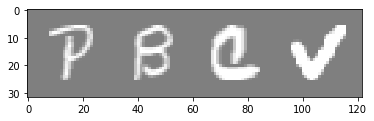

GroundTruth:      P     B     C     V
Predicted:      P     B     C     V


In [20]:
# check predictions by printing the output image for random test inputs.
dataiter = iter(Alph_test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % chr(labels[j]+65) for j in range(4)))

outputs=Alph_net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % chr(predicted[j]+65) for j in range(4)))